# Multi‐Label Multi‐Class Classification Example with Bag of Words

# 1. Imports & Setup

In [ ]:
!pip install transformers datasets


from transformers import AutoModel, AutoTokenizer, Wav2Vec2CTCTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel, AutoTokenizer, Wav2Vec2CTCTokenizer
from tqdm import tqdm
import os


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# 2. Load Dataset and Device setup


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

TRAIN_PATH = "/content/train_esp.csv"
VAL_PATH   = "/content/dev_esp.csv"
TEST_PATH  = "/content/test_esp.csv"

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)

LABEL_COLS = ["anger", "disgust" ,"fear", "joy", "sadness", "surprise"]
TEXT_VAR   = "text"

In [ ]:
train_df.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,esp_train_track_b_00001,"2018 y lo sigo escuchando Like si tú también ,...",0,0,0,3,0,0
1,esp_train_track_b_00002,No les aguas. Caso a los pen...sativos de los ...,0,2,0,0,0,0
2,esp_train_track_b_00003,yo ya estoy.cagandome de risa pero jajajaaja e...,0,0,0,3,0,0
3,esp_train_track_b_00004,Donde le pongo donde son tontos y asquerosos y...,2,2,0,0,0,0
4,esp_train_track_b_00005,"El ritmo está bien, la letra es un asco y quié...",0,2,0,0,0,0


In [ ]:
train_df.value_counts(LABEL_COLS)

anger  disgust  fear  joy  sadness  surprise
0      0        0     2    0        0           357
2      2        0     0    0        0           233
0      0        2     0    0        0           171
                0     0    0        2           144
                           2        0           126
                                               ... 
                2     3    0        0             1
2      1        0     2    0        0             1
       2        0     0    0        1             1
0      0        0     0    3        2             1
                      1    2        2             1
Name: count, Length: 123, dtype: int64

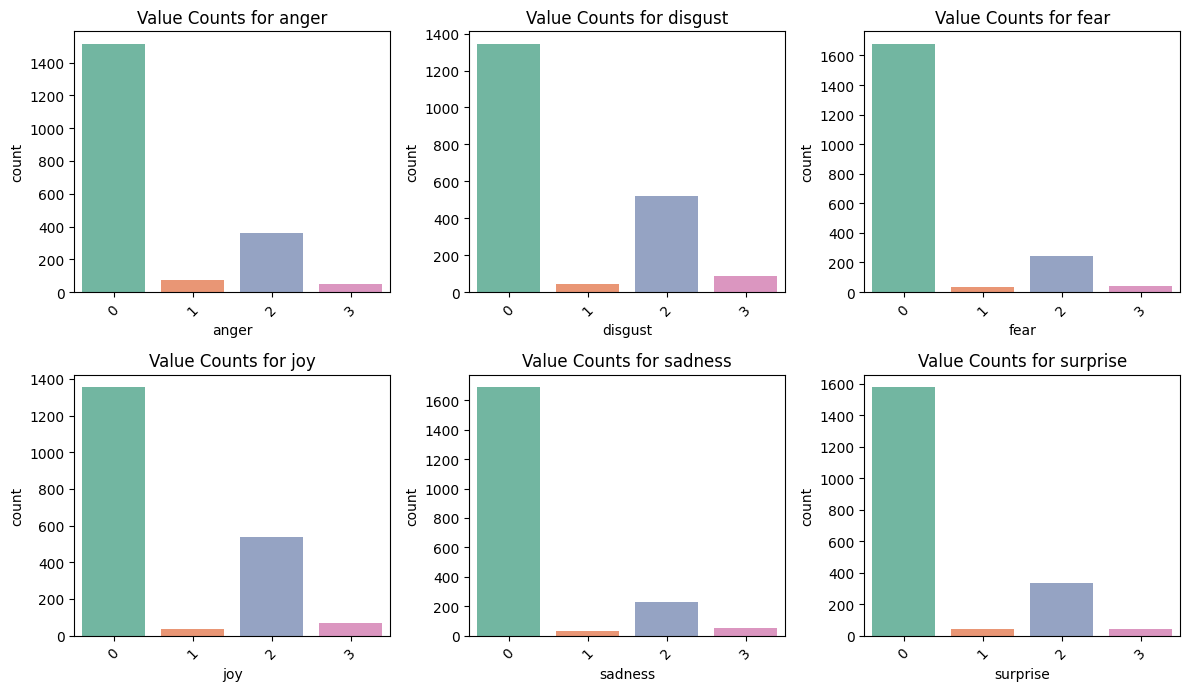

In [ ]:
# Set up the plotting area (adjust size as needed)
plt.figure(figsize=(12, 10))

# Plot each categorical column's value counts
# Changed 'few_category_columns' to 'LABEL_COLS'
# Changed 'df' to 'train_df'
for i, col in enumerate(LABEL_COLS):
    plt.subplot(3, 3, i+1)  # Adjust grid size (3x3 here)
    sns.countplot(x=col, data=train_df, palette='Set2')
    plt.title(f'Value Counts for {col}') # Changed title for better clarity
    plt.xticks(rotation=45)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

# 3. Bag of Words Vectorization

In [ ]:
# Initialize BoW vectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words="english")

# Fit and transform datasets
vectorizer.fit(train_df[TEXT_VAR].fillna(""))  # Fit on the training set
train_bow = vectorizer.transform(train_df[TEXT_VAR].fillna("")).toarray()
val_bow = vectorizer.transform(val_df[TEXT_VAR].fillna("")).toarray()
test_bow = vectorizer.transform(test_df[TEXT_VAR].fillna("")).toarray()

print("BoW Train Shape:", train_bow.shape)
print("BoW Validation Shape:", val_bow.shape)
print("BoW Test Shape:", test_bow.shape)

BoW Train Shape: (1996, 1000)
BoW Validation Shape: (184, 1000)
BoW Test Shape: (1695, 1000)


# 4. Load Tokenizer & Model for Embedding Extraction

In [ ]:
model_name = "Eze-Mz/robertuito-emotion-analysis-finetuned-emotion"
text_tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/435M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at Eze-Mz/robertuito-emotion-analysis-finetuned-emotion and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Extract Text Embeddings

In [ ]:
def extract_text_embeddings(df, save_path, model, tokenizer):
    """Extract [CLS] embeddings from the given model for each row in df."""
    if os.path.exists(save_path):
        print(f"Embeddings already exist at {save_path}")
        return torch.load(save_path)

    embeddings = {}
    model.eval()
    with torch.no_grad():
        for idx, row in tqdm(df.iterrows(), desc="Extracting text embeddings", total=len(df)):
            text_sample = row[TEXT_VAR]
            text_sample = text_sample if isinstance(text_sample, str) else ""

            inputs = tokenizer(
                text_sample,
                padding="max_length",
                truncation=True,
                max_length=512,
                return_tensors="pt"
            ).to(device)

            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings[idx] = cls_embedding.cpu()

    torch.save(embeddings, save_path)
    return embeddings

train_text_embeddings = extract_text_embeddings(train_df, "train_text_embeddings.pt", text_model, text_tokenizer)
val_text_embeddings   = extract_text_embeddings(val_df,   "val_text_embeddings.pt",   text_model, text_tokenizer)
test_text_embeddings  = extract_text_embeddings(test_df,  "test_text_embeddings.pt",  text_model, text_tokenizer)

Embeddings already exist at train_text_embeddings.pt
Embeddings already exist at val_text_embeddings.pt
Embeddings already exist at test_text_embeddings.pt


# 6. Prepare Embeddings with BoW

In [ ]:
def prepare_text_embeddings_with_bow(text_embeddings, df, bow_features, label_cols=None, has_labels=True):
    """
    Combine transformer embeddings with BoW features for each row.
    """
    combined_embeddings = []
    labels = []

    for idx, row in df.iterrows():
        if idx not in text_embeddings:
            continue

        # Transformer embeddings
        text_embedding = text_embeddings[idx].squeeze()  # shape: (768,)

        # BoW features
        bow_vector = torch.tensor(bow_features[idx], dtype=torch.float)  # shape: (1000,)

        # Combine transformer embeddings and BoW features
        combined_vector = torch.cat((text_embedding, bow_vector))  # shape: (1768,)
        combined_embeddings.append(combined_vector)

        if has_labels and label_cols is not None:
            # Labels as integers
            label_vector = row[label_cols].values.astype(int)  # shape: (5,)
            labels.append(label_vector)

    if has_labels and label_cols is not None:
        X = torch.stack(combined_embeddings)
        Y = torch.tensor(labels, dtype=torch.long)
        return X, Y
    else:
        return torch.stack(combined_embeddings)

X_train, y_train = prepare_text_embeddings_with_bow(train_text_embeddings, train_df, train_bow, LABEL_COLS, has_labels=True)
X_val, y_val = prepare_text_embeddings_with_bow(val_text_embeddings, val_df, val_bow, LABEL_COLS, has_labels=True)
X_test = prepare_text_embeddings_with_bow(test_text_embeddings, test_df, test_bow, LABEL_COLS, has_labels=False)

print("X_train Shape:", X_train.shape)
print("X_val Shape:", X_val.shape)
print("X_test Shape:", X_test.shape)

X_train Shape: torch.Size([1996, 1768])
X_val Shape: torch.Size([184, 1768])
X_test Shape: torch.Size([1695, 1768])


# 7. Define MLP Model

In [ ]:
class MLPModel(nn.Module):
    """
    Output dimension now: 5 labels * 4 classes = 20.
    We'll reshape final logits to (batch_size, 5, 4).
    """
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.3):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.flatten = nn.Flatten()


    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
# Updated input dimension
input_dim = 768 + 1000  # Transformer embeddings + BoW features
hidden_dim = [512, 256]
output_dim = len(LABEL_COLS) * 4  # 5 labels * 4 classes
dropout_p = 0.3
model = MLPModel(input_dim, hidden_dim, output_dim, dropout_p).to(device)

# 8. Loss Function and Optimizer

In [ ]:
class MultiLabelMultiClassLoss(nn.Module):
    """Custom loss for multi-label multi-class classification."""
    def __init__(self, num_labels=6, num_classes=4):
        super().__init__()
        self.num_labels = num_labels
        self.num_classes = num_classes
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        batch_size = logits.size(0)
        logits = logits.view(batch_size, self.num_labels, self.num_classes)
        total_loss = 0.0
        for i in range(self.num_labels):
            total_loss += self.ce(logits[:, i, :], targets[:, i])
        return total_loss / self.num_labels

criterion = MultiLabelMultiClassLoss(num_labels=len(LABEL_COLS), num_classes=4)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# 9. Dataloaders

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# 10. Metrics

In [ ]:
def calculate_metrics(logits_list, labels_list):
    """Calculate macro precision, recall, F1, and accuracy."""
    all_logits = torch.cat(logits_list, dim=0)
    all_labels = torch.cat(labels_list, dim=0)

    N = all_logits.size(0)
    all_logits = all_logits.view(N, 6, 4)
    preds = torch.argmax(all_logits, dim=2)

    preds_flat = preds.view(-1).cpu().numpy()
    labels_flat = all_labels.view(-1).cpu().numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels_flat, preds_flat, average="macro", zero_division=0
    )
    accuracy = (preds_flat == labels_flat).mean()

    return accuracy, precision, recall, f1

# 11. Train and Validate

In [ ]:
def train_and_save_best_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_dir):
    best_f1 = -float("inf")
    best_model_path = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        logits_list_train, labels_list_train = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            logits_list_train.append(outputs.detach())
            labels_list_train.append(labels.detach())

        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(logits_list_train, labels_list_train)
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        logits_list_val, labels_list_val = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                logits_list_val.append(outputs)
                labels_list_val.append(labels)

        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(logits_list_val, labels_list_val)
        val_loss /= len(val_loader)

        print(
            f"Epoch {epoch+1}/{num_epochs} "
            f"Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}, F1: {train_f1:.4f} | "
            f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}"
        )

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_path = os.path.join(save_dir, f"best_model_epoch_{epoch+1}_f1_{val_f1:.4f}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with F1: {val_f1:.4f} at epoch {epoch+1}")

    return best_model_path

save_dir = "./models"
os.makedirs(save_dir, exist_ok=True)

best_model_path = train_and_save_best_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, save_dir=save_dir)

print(f"Best model saved at: {best_model_path}")

Epoch 1/100 Train Loss: 0.1433, Acc: 0.9502, F1: 0.7545 | Val Loss: 0.7570, Acc: 0.8152, F1: 0.4006
Best model saved with F1: 0.4006 at epoch 1
Epoch 2/100 Train Loss: 0.1410, Acc: 0.9536, F1: 0.7603 | Val Loss: 0.7485, Acc: 0.8107, F1: 0.3832
Epoch 3/100 Train Loss: 0.1301, Acc: 0.9569, F1: 0.7832 | Val Loss: 0.7551, Acc: 0.8080, F1: 0.3945
Epoch 4/100 Train Loss: 0.1332, Acc: 0.9557, F1: 0.7799 | Val Loss: 0.7494, Acc: 0.8098, F1: 0.3914
Epoch 5/100 Train Loss: 0.1306, Acc: 0.9567, F1: 0.7996 | Val Loss: 0.7699, Acc: 0.8143, F1: 0.3801
Epoch 6/100 Train Loss: 0.1322, Acc: 0.9554, F1: 0.7827 | Val Loss: 0.7668, Acc: 0.8043, F1: 0.3930
Epoch 7/100 Train Loss: 0.1246, Acc: 0.9588, F1: 0.8072 | Val Loss: 0.7902, Acc: 0.8161, F1: 0.3782
Epoch 8/100 Train Loss: 0.1226, Acc: 0.9585, F1: 0.7981 | Val Loss: 0.8156, Acc: 0.8098, F1: 0.4038
Best model saved with F1: 0.4038 at epoch 8
Epoch 9/100 Train Loss: 0.1229, Acc: 0.9592, F1: 0.8109 | Val Loss: 0.7948, Acc: 0.8116, F1: 0.4158
Best model s

# 12. Test Predictions

In [ ]:
def predict_and_generate_submission(test_loader, best_model_path, submission_file_path):
    inference_model = MLPModel(input_dim, hidden_dim, output_dim, dropout_p).to(device)
    inference_model.load_state_dict(torch.load(best_model_path))
    inference_model.eval()

    test_predictions = []
    with torch.no_grad():
        for (inputs,) in test_loader:
            inputs = inputs.to(device)
            outputs = inference_model(inputs)
            batch_size = outputs.size(0)
            outputs = outputs.view(batch_size, 6, 4)
            preds = torch.argmax(outputs, dim=2)
            test_predictions.append(preds.cpu())

    test_predictions = torch.cat(test_predictions, dim=0).numpy()

    submission_df = pd.DataFrame({
        "id": test_df["id"],
        "anger": test_predictions[:, 0],
        "disgust": test_predictions[:, 1],
        "fear": test_predictions[:, 2],
        "joy": test_predictions[:, 3],
        "sadness": test_predictions[:, 4],
        "surprise": test_predictions[:, 5]
    })

    submission_df.to_csv(submission_file_path, index=False)
    print(f"Submission file saved to {submission_file_path}")
    return submission_df

submission_file_path = "submission.csv"
submission_df = predict_and_generate_submission(test_loader, best_model_path, submission_file_path)
submission_df.head()

Submission file saved to submission.csv


,id,anger,disgust,fear,joy,sadness,surprise
0,esp_test_track_b_00001,0,0,0,0,2,0
1,esp_test_track_b_00002,0,0,0,0,0,0
2,esp_test_track_b_00003,0,0,0,0,0,0
3,esp_test_track_b_00004,0,0,0,3,0,0
4,esp_test_track_b_00005,0,2,0,0,0,0
